In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# DATA SETS Y LIMPIEZA

In [2]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep= ';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

In [3]:
hypotheses.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [5]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [6]:
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


# Parte 1. Priorizar hipótesis

In [9]:
hypotheses.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [10]:
# Calcular ICE y RICE
hypotheses['ICE'] = hypotheses['Impact']*hypotheses['Confidence']/hypotheses['Effort']
hypotheses['RICE'] = hypotheses['Reach']*hypotheses['Impact']*hypotheses['Confidence']/hypotheses['Effort']

In [11]:
display(hypotheses.sort_values(by='ICE', ascending= False))
display(hypotheses.sort_values(by='RICE', ascending= False))

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


# Parte 2. Análisis del test A/B

## 1.- Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

In [12]:
datesGroup = orders[['date', 'group']].drop_duplicates()

ordersAgg = datesGroup.apply(
    lambda x: orders[
        (orders['date'] <= x['date']) & (orders['group'] == x['group'])
    ].agg({
        'date': 'max',
        'group': 'max',
        'transactionId': pd.Series.nunique,
        'visitorId': pd.Series.nunique,
        'revenue': 'sum'
    }),
    axis=1
).sort_values(by=['date', 'group']).reset_index(drop=True)

In [13]:
datesGroup_visits = visits[['date', 'group']].drop_duplicates()

visitsAgg = datesGroup_visits.apply(
    lambda x: visits[
        (visits['date'] <= x['date']) & (visits['group'] == x['group'])
    ].agg({
        'date': 'max',
        'group': 'max',
        'visits': 'sum'
    }),
    axis=1
).sort_values(by=['date', 'group']).reset_index(drop=True)

In [14]:
cumulative_data= ordersAgg.merge(visitsAgg, left_on = ['date','group'], right_on = ['date','group'])
cumulative_data.columns = ('date','group', 'orders', 'buyers', 'revenue', 'visitors')
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,2356.8,719
1,2019-08-01,B,21,20,1620.0,713
2,2019-08-02,A,44,38,3860.3,1338
3,2019-08-02,B,45,43,4243.8,1294
4,2019-08-03,A,68,62,5675.5,1845


In [15]:
cumulative_dataA = cumulative_data[cumulative_data['group'] == 'A'][['date','revenue','orders']]
cumulative_dataB = cumulative_data[cumulative_data['group'] == 'B'][['date','revenue','orders']]

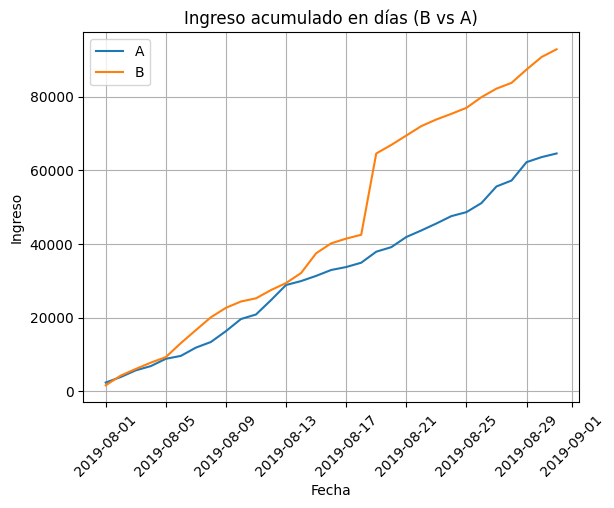

In [16]:
plt.plot(cumulative_dataA['date'], cumulative_dataA['revenue'], label='A')
plt.plot(cumulative_dataB['date'], cumulative_dataB['revenue'], label='B')
plt.title('Ingreso acumulado en días (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Ingreso')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

### Segun el grafico, inician muy iguales, pero el grupo B va teniendo un incremento importante y el grupo A se mantiene consistente en sus numeros.

## 2.-Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

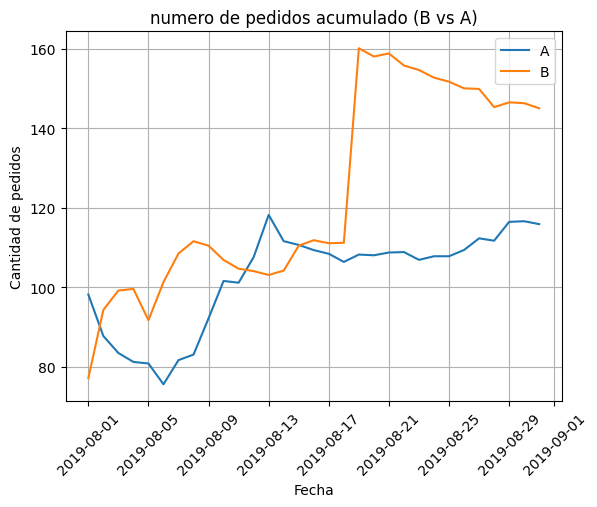

In [17]:
proportionA = cumulative_dataA['revenue']/ cumulative_dataA['orders']
proportionB = cumulative_dataB['revenue']/ cumulative_dataB['orders']

plt.plot(cumulative_dataA['date'], proportionA, label='A')
plt.plot(cumulative_dataB['date'], proportionB, label='B')
plt.title('numero de pedidos acumulado (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pedidos')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

### Parece que hay una fecha donde el numero de pedidos se dispara para el grupo B coincide con el incremento de ingresos del grafico pasado, el incremento de ingresos no es por los precios es por el numero de pedidos, puede seer que se haya llevado a cabo una promoción.

## 3.- Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas.

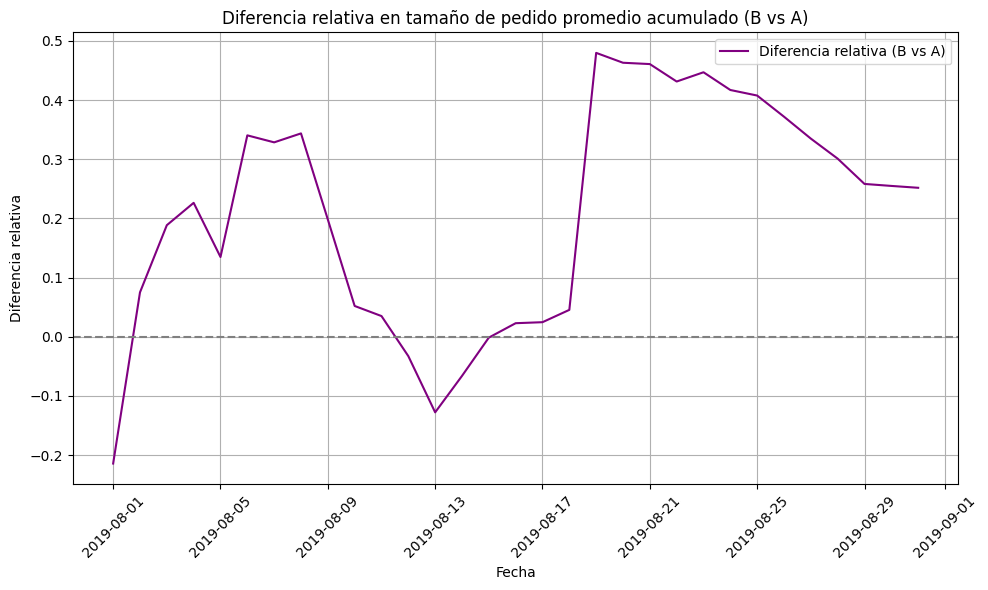

In [18]:
aov_A = cumulative_dataA['revenue'] / cumulative_dataA['orders']
aov_B = cumulative_dataB['revenue'] / cumulative_dataB['orders']

# Calcula la diferencia relativa
relative_diff = (aov_B.values - aov_A.values) / aov_A.values


plt.figure(figsize=(10, 6))
plt.plot(cumulative_dataA['date'].values, relative_diff, label='Diferencia relativa (B vs A)', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Diferencia relativa en tamaño de pedido promedio acumulado (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Tomando como base el grupo A y viendo la fluctuación de B notamos que entre el 17 de agosto y el 21 de agosto incrementó mucho los pedidos, ya habia ocurrido un incremento como por el 6 de agosto pero no fue consistente y de hecho disminuyoo seriamente el numero hasta el 13 de agosto, pero un cambio significativo elevaron los pedidos fuertemente.

## 4.-Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. Saca conclusiones y haz conjeturas.

In [19]:
daily_orders = orders.groupby(['date', 'group']).agg({'transactionId': 'nunique'}).reset_index()
daily_orders.columns = ('date', 'group', 'orders')
daily_orders

daily_visits = visits.copy()
conversion_data = daily_orders.merge(daily_visits, on=['date', 'group'])
conversion_data['conversion_rate'] = conversion_data['orders'] / conversion_data['visits']

conversion_data.head()

,date,group,orders,visits,conversion_rate
0,2019-08-01,A,24,719,0.033380
1,2019-08-01,B,21,713,0.029453
2,2019-08-02,A,20,619,0.032310
3,2019-08-02,B,24,581,0.041308
4,2019-08-03,A,24,507,0.047337


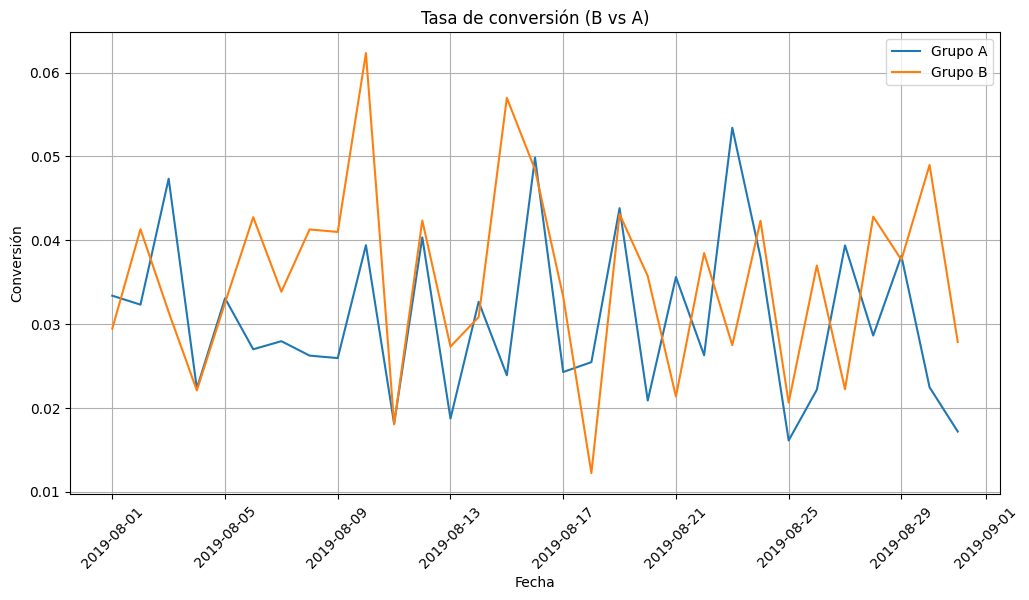

In [20]:
conversion_A = conversion_data[conversion_data['group'] == 'A']
conversion_B = conversion_data[conversion_data['group'] == 'B']

plt.figure(figsize=(12, 6))
plt.plot(conversion_A['date'], conversion_A['conversion_rate'], label='Grupo A')
plt.plot(conversion_B['date'], conversion_B['conversion_rate'], label='Grupo B')
plt.title('Tasa de conversión (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Conversión')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Ambos grupos tiuenen una conversión fluctuante , osea nada estable, la deel Grupo B es mayor pero hay puntos, a mediados de mes para adelante, del grupo A que son significativos.

## 5.-Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.

In [21]:
orders_by_user = orders.groupby('visitorId')['transactionId'].nunique().reset_index()
orders_by_user.columns = ['visitorId', 'orders']

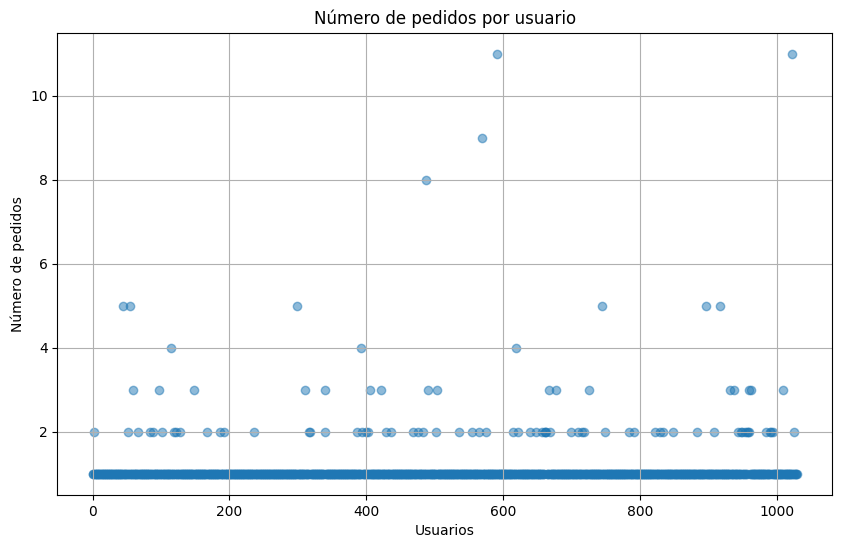

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(orders_by_user)), orders_by_user['orders'], alpha=0.5)
plt.title('Número de pedidos por usuario')
plt.xlabel('Usuarios')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

### La mayoria de los usuarios no pasan de 3-4 pedidos, hay casos de mas de 10 pero se duda que sea mas del 1%

## 6.-Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [23]:
print('Percentiles 95/99 de número de pedidos:',np.percentile(orders_by_user['orders'],[95, 99] ))

Percentiles 95/99 de número de pedidos: [2. 4.]


## Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.

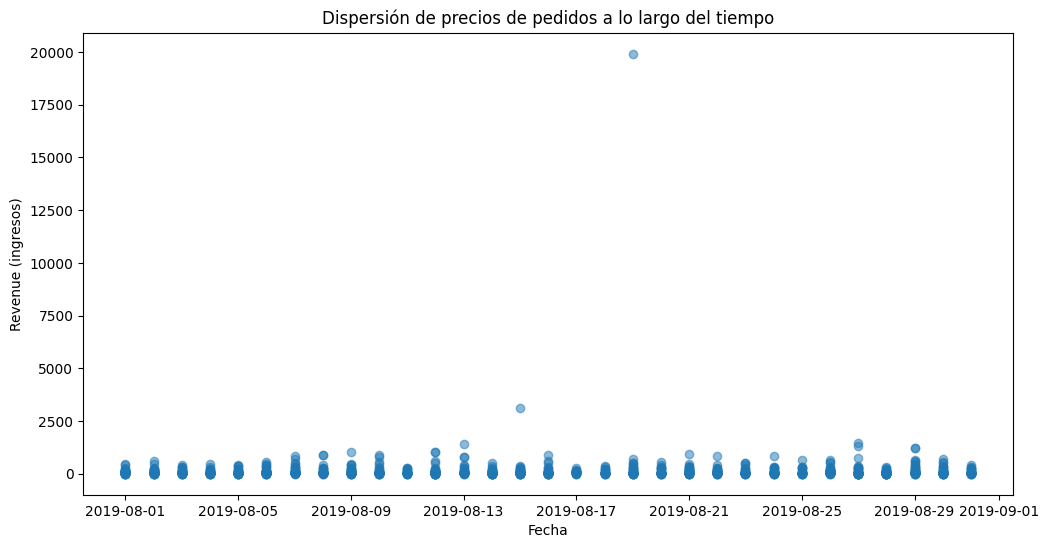

In [24]:
plt.figure(figsize=(12, 6))
plt.scatter(orders['date'], orders['revenue'], alpha=0.5)
plt.title('Dispersión de precios de pedidos a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Revenue (ingresos)')
plt.show()

### Hay una gran mayoria de ingresos de menos de 2500 y parece que hay un dato totalmente atipico de 20 000 que seguramente nos distorsiona totalmente los datos ya que es 10 veces mas grande, procederemnos a filtrar.

## 8.- Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [25]:
print('Percentiles 95/99 de precios de pedidos:',np.percentile(orders['revenue'],[95, 99] ))

Percentiles 95/99 de precios de pedidos: [435.54  900.904]


## 9.- Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [26]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

In [27]:
total_visitors_A = visits[visits['group'] == 'A']['visits'].sum()
total_visitors_B = visits[visits['group'] == 'B']['visits'].sum()

sampleA = pd.concat([
    ordersByUsersA['orders'],
    pd.Series(
        0,
        index=np.arange(total_visitors_A - len(ordersByUsersA)),
        name='orders'
    )
])

sampleB = pd.concat([
    ordersByUsersB['orders'],
    pd.Series(
        0,
        index=np.arange(total_visitors_B - len(ordersByUsersB)),
        name='orders'
    )
])

In [28]:
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
relative_diff = sampleB.mean() / sampleA.mean() - 1

print(f"P-valor: {p_value:.5f}")
print(f"Diferencia relativa: {relative_diff:.2%}")

if p_value < 0.05:
    print("✅ La diferencia en la conversión entre los grupos es estadísticamente significativa.")
else:
    print("ℹ️ No hay evidencia suficiente para afirmar una diferencia significativa.")

P-valor: 0.01679
Diferencia relativa: 13.81%
✅ La diferencia en la conversión entre los grupos es estadísticamente significativa.


## 10.- Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [29]:
revenues_A = orders[orders['group'] == 'A']['revenue']
revenues_B = orders[orders['group'] == 'B']['revenue']

p_value = stats.mannwhitneyu(revenues_A, revenues_B)[1]
relative_diff = revenues_B.mean() / revenues_A.mean() - 1

print(f"P-valor: {p_value:.5f}")
print(f"Diferencia relativa en tamaño promedio de pedido: {relative_diff:.2%}")

if p_value < 0.05:
    print("✅ Hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.")
else:
    print("ℹ️ No hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.")

P-valor: 0.69152
Diferencia relativa en tamaño promedio de pedido: 25.17%
ℹ️ No hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.


## 11.-Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [30]:
orders_by_user = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
orders_by_user.columns = ['visitorId', 'num_orders']

valid_users = orders_by_user[orders_by_user['num_orders'] <= 4]['visitorId']
filtered_orders = orders[orders['visitorId'].isin(valid_users)].copy()


In [31]:
orders_by_user_A = filtered_orders[filtered_orders['group'] == 'A']['visitorId'].nunique()
orders_by_user_B = filtered_orders[filtered_orders['group'] == 'B']['visitorId'].nunique()

visitors_A = visits[visits['group'] == 'A']['visits'].sum()
visitors_B = visits[visits['group'] == 'B']['visits'].sum()

sample_A = np.concatenate([
    np.ones(orders_by_user_A),                     
    np.zeros(visitors_A - orders_by_user_A)        
])

sample_B = np.concatenate([
    np.ones(orders_by_user_B),
    np.zeros(visitors_B - orders_by_user_B)
])

p_value = stats.mannwhitneyu(sample_A, sample_B)[1]
relative_diff = sample_B.mean() / sample_A.mean() - 1

print(f"p-valor: {p_value:.5f}")
print(f"Diferencia relativa en conversión: {relative_diff:.3%}")

if p_value < 0.05:
    print("✅ Hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.")
else:
    print("ℹ️ No hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.")

p-valor: 0.01566
Diferencia relativa en conversión: 15.724%
✅ Hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.


## 12.- Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [32]:
filtered_orders_rev = filtered_orders[filtered_orders['revenue'] <= 435.54]

orders_by_user_A_rev = filtered_orders_rev[filtered_orders_rev['group'] == 'A']['visitorId'].nunique()
orders_by_user_B_rev = filtered_orders_rev[filtered_orders_rev['group'] == 'B']['visitorId'].nunique()


visitors_A = visits[visits['group'] == 'A']['visits'].sum()
visitors_B = visits[visits['group'] == 'B']['visits'].sum()



In [33]:
sample_A_rev = np.concatenate([
    np.ones(orders_by_user_A_rev),
    np.zeros(visitors_A - orders_by_user_A_rev)
])

sample_B_rev = np.concatenate([
    np.ones(orders_by_user_B_rev),
    np.zeros(visitors_B - orders_by_user_B_rev)
])

p_value_rev = stats.mannwhitneyu(sample_A_rev, sample_B_rev)[1]
relative_diff_rev = sample_B_rev.mean() / sample_A_rev.mean() - 1

print(f"p-valor (revenue filtrado): {p_value_rev:.5f}")
print(f"Diferencia relativa en conversión (revenue filtrado): {relative_diff_rev:.3%}")

if p_value < 0.05:
    print("✅ Hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.")
else:
    print("ℹ️ No hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.")

p-valor (revenue filtrado): 0.02000
Diferencia relativa en conversión (revenue filtrado): 15.521%
✅ Hay una diferencia estadísticamente significativa en el tamaño promedio del pedido entre los grupos.


## 13.- Toma una decisión basada en los resultados de la prueba. Las decisiones posibles son: 1. Parar la prueba, considerar a uno de los grupos como líder. 2. Parar la prueba, concluir que no hay diferencia entre los grupos. 3. Continuar la prueba.

### CONCLUSIÓN DE LA PRUEBA, SEGUN LOS DATOS EL GRUPO B ES CONSISTENTEMENTE SUPERIOR AL GRUPO A, EN LA PARTE DE NUMERO DE PEDIDOS TANTO EL FILTRADO COMO EL NO FILTRADO RELFEJAN LA DIFERENCIA, EN EL REVENUE LA VERSIÓN SIN FILTRAR NO MOSTRABA ESA DIFERENCIA SIGNIFICATIVA PERO EN LA VERSIÓN FILTRADA CON EL 95% DE LOS DATOS SI MARCA LA DIFERENCIA, ESTO POR QUE EN EL 5% EXISTEN DATOS MUY MUY INFLADOS QUE AFECTAN LA PRUEBA SIN FILTRAR, ENTONCES LA COPNCLUSIÓN, NUEVAMENTE, ES LA 1, PARAMOS Y EL GRUPO B ES SUPERIOR.